## Q Learning Network가 발산하는 이유

* Correlation between samples: Cartpole을 하다보면 action에 대해 변화하는 state가 미세하게 변경되기 때문에 매우 비슷한 상태가 많이 주어짐
    * 비슷한 상태를 국소적으로 많이 학습하면 전체 경향을 제대로 파악하지 못함
    * experience replay로 해결
* Non-stationary targets: Q network를 Q target에 가까워지도록 업데이트를 할 때 두 네트워크는 같은 weight를 공유하기 때문에 Q network가 학습이 이뤄지는 순간 Q target도 값이 바뀜
    * 계속 바뀌는 목표에 대해 수렴하기 힘듦
    * separate network로 해결

DQN에서는 1. deep neural network, 2. experience replay, 3. separate network를 사용함

In [1]:
import gymnasium
import numpy as np
import torch
import torch.nn.init

In [2]:
env = gymnasium.make('CartPole-v1')
q = torch.empty(*env.observation_space.shape, env.action_space.n).requires_grad_()
torch.nn.init.xavier_uniform_(q)
q

tensor([[-0.2616,  0.9361],
        [ 0.3272,  0.6008],
        [-0.2074,  0.0625],
        [ 0.9228,  0.8590]], requires_grad=True)

In [3]:
lr = 0.1
discount = 0.9
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam([q], lr=lr)

In [4]:
num_episodes = 4000
rewards = []
for i in range(num_episodes):
    u, info = env.reset()
    reward = 0
    while True:
        e = 1 / (i / 50 + 10)
        u = torch.tensor(u)
        uq = u @ q
        if np.random.random() < e:
            action = env.action_space.sample()
        else:
            action = torch.argmax(uq).cpu().detach().item()
        v, r, terminated, truncated, info = env.step(action)
        reward += r
        target_q = uq.clone()
        if terminated:
            target_q[action] = -100
        else:
            target_q[action] = r + discount * torch.max(q[v, :])
        loss = criterion(target_q, uq)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        u = v
        if terminated or truncated:
            break
    rewards.append(reward)


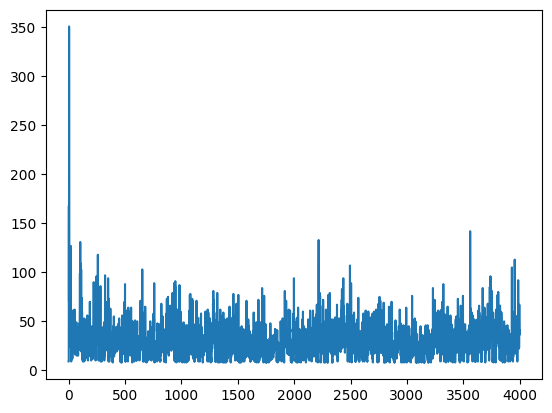

In [5]:
import matplotlib.pyplot as plt
plt.plot(rewards)

In [8]:
env = gymnasium.make('CartPole-v1', render_mode='human')
rewards = []
for i in range(10):
    reward = 0
    u, info = env.reset()
    while True:
        u = torch.tensor(u)
        action = torch.argmax(u @ q).cpu().detach().item()
        v, r, terminated, truncated, info = env.step(action)
        reward += r
        u = v
        if terminated or truncated:
            break
    rewards.append(reward)
env.close()
rewards

[24.0, 31.0, 27.0, 29.0, 17.0, 24.0, 18.0, 33.0, 22.0, 31.0]